<a href="https://colab.research.google.com/github/virtualms/IssProject/blob/master/performer_bert_t5ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

As said in the official repository of glue:

The [GLUE](https://gluebenchmark.com/) Benchmark is a group of nine classification tasks on sentences or pairs of sentences which are:

- [CoLA](https://nyu-mll.github.io/CoLA/) (Corpus of Linguistic Acceptability) Determine if a sentence is grammatically correct or not.is a  dataset containing sentences labeled grammatically correct or not.
- [MNLI](https://arxiv.org/abs/1704.05426) (Multi-Genre Natural Language Inference) Determine if a sentence entails, contradicts or is unrelated to a given hypothesis. (This dataset has two versions, one with the validation and test set coming from the same distribution, another called mismatched where the validation and test use out-of-domain data.)
- [MRPC](https://www.microsoft.com/en-us/download/details.aspx?id=52398) (Microsoft Research Paraphrase Corpus) Determine if two sentences are paraphrases from one another or not.
- [QNLI](https://rajpurkar.github.io/SQuAD-explorer/) (Question-answering Natural Language Inference) Determine if the answer to a question is in the second sentence or not. (This dataset is built from the SQuAD dataset.)
- [QQP](https://data.quora.com/First-Quora-Dataset-Release-Question-Pairs) (Quora Question Pairs2) Determine if two questions are semantically equivalent or not.
- [RTE](https://aclweb.org/aclwiki/Recognizing_Textual_Entailment) (Recognizing Textual Entailment) Determine if a sentence entails a given hypothesis or not.
- [SST-2](https://nlp.stanford.edu/sentiment/index.html) (Stanford Sentiment Treebank) Determine if the sentence has a positive or negative sentiment.
- [STS-B](http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark) (Semantic Textual Similarity Benchmark) Determine the similarity of two sentences with a score from 1 to 5.
- [WNLI](https://cs.nyu.edu/faculty/davise/papers/WinogradSchemas/WS.html) (Winograd Natural Language Inference) Determine if a sentence with an anonymous pronoun and a sentence with this pronoun replaced are entailed or not. (This dataset is built from the Winograd Schema Challenge dataset.)

In this notebook we will what kind of performance can garantee a model with linear attention. In particular, we will try Performer for Bert and DistilBert families of model (also due to computational constraint) + T5. **Important**: due to computational constraints, we will perfom GLUE.SST2 test (i.e sentiment analysis). Onlu a couple of training epochs take 40m foreach model!

For the experiment, I reccomend to follow a guide notebook by huggingface [colab](https://colab.research.google.com/github/huggingface/notebooks/blob/master/examples/text_classification.ipynb#scrollTo=MOsHUjgdIrIW)

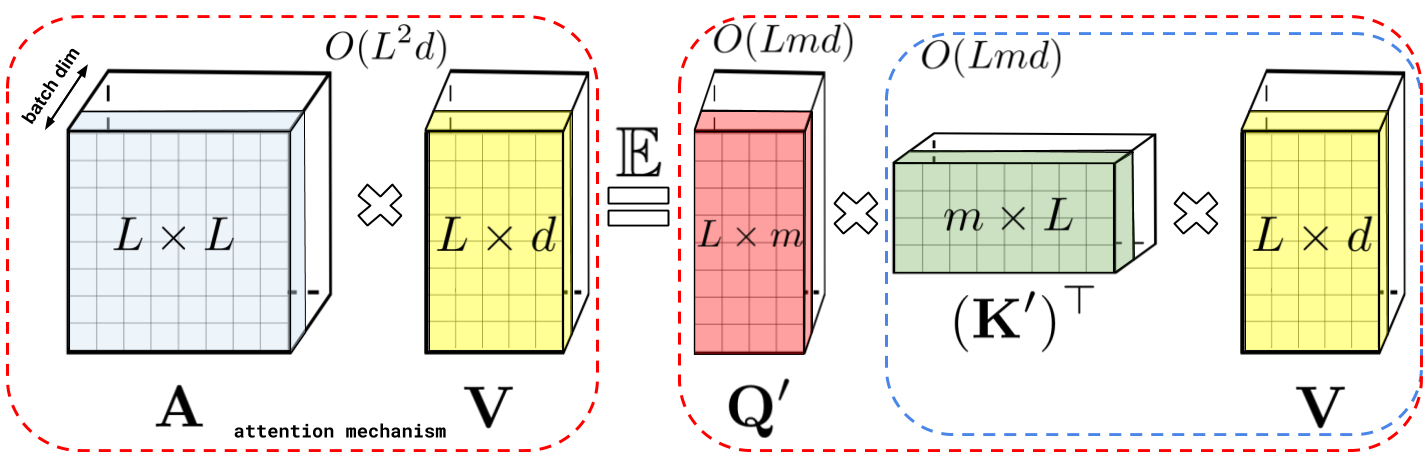

Actually the linear attention is not part of the master branch of the huge transformers library. For the entire notebook, we will use a great implementation provided in a recent fork. You can find it [here](https://github.com/Muennighoff/transformers.git).
For the experiment we will use PyTorch because is pretty straightforward because of the transformer library. Also TF/JAX is possible. 

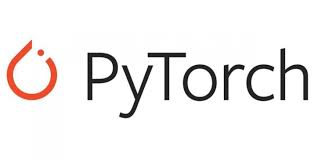

# Installing required dependencies

Here we install the requested dependencies. Keep in mind we will not use the master branch of transformers, so you need to install the library like below (the process can take several minutes).

(As shown in [issues](https://github.com/huggingface/transformers/issues/7675))

In [ ]:
!git clone https://github.com/Muennighoff/transformers.git
!cd trans*; pip install -q -e '.[dev]'
%cd transformers/src
!pip install -q datasets

#DistilBert

A distil about DistilBert. The [DistilBERT](https://huggingface.co/transformers/model_doc/distilbert.html) model is a distilled version of BERT, and was proposed in the paper [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/abs/1910.01108). DistilBERT is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

We will download pretrained models from [model hub](https://huggingface.co/models), and then we will perform a few training steps for each test.

## Run

Here are listed all the tasks

In [ ]:
GLUE_TASKS = ["cola", "mnli", "mnli-mm", "mrpc", "qnli", "qqp", "rte", "sst2", "stsb", "wnli"]

In [ ]:
task = "sst2" #https://paperswithcode.com/sota/sentiment-analysis-on-sst-2-binary
model_checkpoint = "distilbert-base-uncased"
batch_size = 8
lr = 1e-5
num_train_epochs = 2 #40m!!! :(

Appendix: If regex does not work, try the command below!

In [ ]:
# !pip install --force-reinstall regex #se non va regex (???)

Loading data, metric and tokenizer from datasets

In [ ]:
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer

import torch
import numpy as np


#useful for later
#see https://huggingface.co/transformers/preprocessing.html
def preprocess_function(examples):
    return tokenizer(examples["sentence"], truncation=True)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

#https://huggingface.co/docs/datasets/how_to.html, "how to process a dataset"
dataset = load_dataset("glue", task)
metric = load_metric("glue", task)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

#obtained tokenized and batched dataset for later
encoded_dataset = dataset.map(preprocess_function, batched=True)

Reusing dataset glue (/root/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Define args for training

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

args = TrainingArguments(
    "test-glue",
    evaluation_strategy = "epoch",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    #num_train_epochs=5,
    num_train_epochs=num_train_epochs
)

Obtaining the model from checkpoint and training it with a trainer

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(model_checkpoint)

trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,0.236100,0.351594,0.904817,3.063500,284.645000


TrainOutput(global_step=8419, training_loss=0.27698639456117674, metrics={'train_runtime': 904.733, 'train_samples_per_second': 9.306, 'total_flos': 805239784165800, 'epoch': 1.0})

We do the same for performer and we check the results

In [ ]:
from transformers import DistilBertPerformerForSequenceClassification

model = DistilBertPerformerForSequenceClassification.from_pretrained(model_checkpoint)

trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertPerformerForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertPerformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertPerformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertPerformerForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['distilbert.transfo

Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,0.312200,0.474547,0.842890,4.998900,174.438000


TrainOutput(global_step=8419, training_loss=0.33875687981263547, metrics={'train_runtime': 1194.0947, 'train_samples_per_second': 7.051, 'total_flos': 819981100016040, 'epoch': 1.0})

## Remarks

# Bert

BERT

In [ ]:
model_checkpoint = "bert-base-uncased"

In [ ]:
model = BertForSequenceClassification.from_pretrained(model_checkpoint)

trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

BERT-performer

In [ ]:
from transformers import BertPerformerForSequenceClassification

model = BertPerformerForSequenceClassification.from_pretrained(model_checkpoint)

trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

## Remarks

# T5

The T5 model was presented in [Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer](https://arxiv.org/pdf/1910.10683.pdf). For more info, consult the [hugging face page](https://huggingface.co/transformers/model_doc/t5.html).

T5 is an encoder-decoder model pre-trained on a multi-task mixture of unsupervised and supervised tasks and for which each task is converted into a text-to-text format. T5 works well on a variety of tasks out-of-the-box by prepending a different prefix to the input corresponding to each task

T5 comes in different sizes:
* t5-small
* t5-base
* t5-large
* ...

Here we will try it in the normal/performer versions.


In [ ]:
model_checkpoint = "t5-base"

General setup

In [ ]:
import torch
import numpy as np
from transformers import T5ForConditionalGeneration, Trainer, TrainingArguments

#like before
encoded_dataset = dataset.map(preprocess_function, batched=True)
encoded_dataset = encoded_dataset.map(preprocess_targets, batched=False)

#https://huggingface.co/transformers/model_doc/t5.html#scripts, seen here
def compute_metrics(eval_pred):

    predictions, labels = eval_pred

    # predictions returns an additonal parameter (the encoder outputs?)
    predictions, _ = predictions

    predictions = np.argmax(predictions, axis=-1)

    print(predictions[:20, 0])
    print(labels[:20, 0])

    # We just take the first token corresponding to positive or negative
    return metric.compute(predictions=predictions[:, 0], references=labels[:, 0])

In [ ]:
args = TrainingArguments(
    "test-glue",
    evaluation_strategy = "epoch",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
)

Transformer only

In [ ]:
model = T5ForSequenceClassification.from_pretrained(model_checkpoint)

trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

+Performer

In [ ]:
model = T5PerformerForSequenceClassification.from_pretrained(model_checkpoint)

trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

## Remarks

ciao